<a href="https://colab.research.google.com/github/NAHIN-JZS/image_colorization/blob/main/Skin_Tone_ResNet50_image_colorization_on_Lab_for_larger_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!pip install -q tensorflow-io

     |████████████████████████████████| 25.0 MB 1.4 MB/s 


In [3]:
from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from tensorflow.keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
import csv

import tensorflow_io as tfio
from tensorflow.keras.layers import MaxPool2D
from tensorflow.keras.applications import ResNet50

In [4]:
def define_discriminator(input_image_shape,output_image_shape):
    
	# weight initialization
	init = RandomNormal(stddev=0.02) #As described in the original paper
    
	# source image input
	in_src_image = Input(shape=input_image_shape)  #Image we want to convert to another image
	# target image input
	in_target_image = Input(shape=output_image_shape)  #Image we want to generate after training. 
    
	# concatenate images, channel-wise
	merged = Concatenate()([in_src_image, in_target_image])
    
	# C64: 4x4 kernel Stride 2x2
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
	d = LeakyReLU(alpha=0.2)(d)
	# C128: 4x4 kernel Stride 2x2
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256: 4x4 kernel Stride 2x2
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer : 4x4 kernel but Stride 1x1
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = BatchNormalization()(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	patch_out = Activation('sigmoid')(d)
	# define model
	model = Model([in_src_image, in_target_image], patch_out)
    
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
	return model

In [5]:

def define_encoder_block(layer_in, n_filters, batchnorm=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add downsampling layer
	g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# conditionally add batch normalization
	if batchnorm:
		g = BatchNormalization()(g, training=True)
	# leaky relu activation
	g = LeakyReLU(alpha=0.2)(g)
	return g


In [6]:
# define a decoder block to be used in generator
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# add upsampling layer
	g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
	# add batch normalization
	g = BatchNormalization()(g, training=True)
	# conditionally add dropout
	if dropout:
		g = Dropout(0.5)(g, training=True)
	# merge with skip connection
	g = Concatenate()([g, skip_in])
	# relu activation
	g = Activation('relu')(g)
	return g

In [7]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [8]:
def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate(axis = -1)([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [9]:
def define_generator(input_image_shape=(512,512,3),output_image_shape=(512,512,3)):
  """ Input """
  inputs = Input(input_image_shape)

  """ Pre-trained ResNet50 Model """
  # resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
  pre_model = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
  # pre_model = tf.keras.applications.MobileNetV2(input_shape = input_image_shape, include_top=False, weights="imagenet")

  """ Encoder """
  # s1 = resnet50.get_layer("input_39").output           ## (512 x 512)
  s2 = pre_model.get_layer("conv1_relu").output        ## (256 x 256)
  s3 = pre_model.get_layer("conv2_block3_out").output  ## (128 x 128)
  s4 = pre_model.get_layer("conv3_block4_out").output  ## (64 x 64)

  '''layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]'''

  # s1 = mobileNet.get_layer('block_1_expand_relu').output
  # s2 = mobileNet.get_layer('block_3_expand_relu').output
  # s3 = mobileNet.get_layer('block_6_expand_relu').output
  # s4 = mobileNet.get_layer('block_13_expand_relu').output
  # s5 = mobileNet.get_layer('block_16_expand_relu').output

  """ Bridge """
  b1 = pre_model.get_layer("conv4_block6_out").output  ## (32 x 32)
  # b1 = mobileNet.get_layer('block_16_expand_relu').output

  """ Decoder """
  d1 = decoder_block(b1, s4, 512)                     ## (64 x 64)
  d2 = decoder_block(d1, s3, 256)                     ## (128 x 128)
  d3 = decoder_block(d2, s2, 128)                     ## (256 x 256)
  # d4 = decoder_block(d3, s1, 64)                      ## (512 x 512)
  # d4 = Conv2DTranspose(64, (2, 2), strides=2, padding="same")(d3)
  # d4 = Concatenate(axis = -1)([x, skip_features])
  # d4 = conv_block(d4, 64)

  """ Output """
  # g = Conv2DTranspose(output_image_shape[2], (4,4), strides=(2,2), padding='same')(d4) #Modified
  g = Conv2DTranspose(output_image_shape[2], (4,4), strides=(2,2), padding='same')(d3) 
  outputs = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1

  model = Model(inputs, outputs, name="ResNet50_U-Net")
  return model

In [10]:
# # define the standalone generator model - U-net
# def define_generator(input_image_shape=(256,256,1),output_image_shape=(256,256,3)):
# 	# weight initialization
# 	init = RandomNormal(stddev=0.02)
# 	# image input
# 	in_image = Input(shape=input_image_shape)
# 	# encoder model: C64-C128-C256-C512-C512-C512-C512-C512
# 	e1 = define_encoder_block(in_image, 64, batchnorm=False)
# 	e2 = define_encoder_block(e1, 128)
# 	e3 = define_encoder_block(e2, 256)
# 	e4 = define_encoder_block(e3, 512)
# 	e5 = define_encoder_block(e4, 512)
# 	e6 = define_encoder_block(e5, 512)
# 	e7 = define_encoder_block(e6, 512)
# 	# bottleneck, no batch norm and relu
# 	b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
# 	b = Activation('relu')(b)
# 	# decoder model: CD512-CD512-CD512-C512-C256-C128-C64
# 	d1 = decoder_block(b, e7, 512)
# 	d2 = decoder_block(d1, e6, 512)
# 	d3 = decoder_block(d2, e5, 512)
# 	d4 = decoder_block(d3, e4, 512, dropout=False)
# 	d5 = decoder_block(d4, e3, 256, dropout=False)
# 	d6 = decoder_block(d5, e2, 128, dropout=False)
# 	d7 = decoder_block(d6, e1, 64, dropout=False)
# 	# output
# 	g = Conv2DTranspose(output_image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified 
# 	out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
# 	# define model
# 	model = Model(in_image, out_image)
# 	return model


In [11]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, input_image_shape,mask_image_shape):
	# make weights in the discriminator not trainable
	for layer in d_model.layers:
		if not isinstance(layer, BatchNormalization):
			layer.trainable = False
            
	# define the source image
	in_src = Input(shape=input_image_shape)
	mask = Input(shape= mask_image_shape)
	# suppy the image as input to the generator 
	gen_out = g_model(in_src)
	
	mask_gen_out = tf.math.multiply(gen_out,mask)
	# supply the input image and generated image as inputs to the discriminator
	dis_out = d_model([in_src, gen_out])
	# src image as input, generated image and disc. output as outputs
	model = Model([in_src,mask], [dis_out, gen_out, mask_gen_out])
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
    
	model.compile(loss=['binary_crossentropy', 'mae', 'mae'], 
               optimizer=opt, loss_weights=[1,50,50])
	return model

In [12]:

def generate_real_samples(dataset, n_samples, patch_shape):
	# unpack dataset
	trainA, trainB = dataset
	# choose random instances
	ix = randint(0, trainA.shape[0], n_samples)
	# retrieve selected images
	X1, X2 = trainA[ix], trainB[ix]
	# X1, X2 = trainA, trainB
	# generate 'real' class labels (1)
	y = ones((n_samples, patch_shape, patch_shape, 1))
	return [X1, X2], y

In [13]:


# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
	#To make the source image into 3 channels so that it can be feed into the resnet50 model
	# samples = np.repeat(samples, repeats = 3, axis = -1)
	# generate fake instance
	X = g_model.predict(samples)
	# create 'fake' class labels (0)
	y = zeros((len(X), patch_shape, patch_shape, 1))
	return X, y

In [14]:
def summarize_performance(step, g_model, d_model, gan_model, weight_folder):
	# select a sample of input images
	
	# save the generator model
	g_model_filename = weight_folder + '/g_model_%06d.h5' % (step+1)
	g_model.save(g_model_filename)
	print('>Saved: %s' % ( g_model_filename))

	# save the discriminator model
	d_model_filename = weight_folder + '/d_model_%06d.h5' % (step+1)
	d_model.save(d_model_filename)
	print('>Saved: %s' % (d_model_filename))

	# save the gan model
	gan_model_filename = weight_folder + '/gan_model_%06d.h5' % (step+1)
	gan_model.save(gan_model_filename)
	print('>Saved: %s' % ( gan_model_filename))


In [15]:
import tensorflow as tf
from os import listdir
from numpy import asarray, load
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np
from PIL import Image, ImageOps

In [16]:
# This function will create a list of image path
def generate_image_path_list(folder_name):
  path_list = list() 
  for filename in listdir(folder_name):
    path_list.append(filename)
  return path_list

In [78]:
# load all images in a directory into memory
def load_images(im_indecator, im_path_list,mask_path_list, im_path,mask_path, batch_size, size=(256,256)):
	src_list, tar_list, mask_list = list(), list(), list()
	# enumerate filenames in directory, assume all are images
	# for filename in listdir(path):
	if ((im_indecator + batch_size) > len(im_path_list)):
		batch_size = len(im_path_list) - im_indecator
	for j in range(batch_size):

		# load and resize the image
		#pixels = load_img(path + filename, target_size=size)
		rgb_image = load_img(path + im_path_list[im_indecator+j], target_size=size)
		#gray_image = ImageOps.grayscale(rgb_image)
		# gray_image = tf.image.rgb_to_grayscale(rgb_image)
		# convert to numpy array
		rgb_pixels = img_to_array(rgb_image)
	
		#-----lab conversion--------#
		rgb_pixels = rgb_pixels/255.0
		lab = tfio.experimental.color.rgb_to_lab(rgb_pixels)
		lab_pixels = (lab)/100.0

		

		# rgb_np_array = np.array(rgb_pixels, dtype=float)
		# lab_pixels = rgb2lab(1.0/255*rgb_np_array)



		gray_pixels = lab_pixels[:,:,0]
		gray_pixels = np.expand_dims(gray_pixels, axis=2)
	
		#To make the source image into 3 channels so that it can be feed into the resnet50 model
		gray_pixels = np.repeat(gray_pixels, repeats = 3, axis = -1)

		ab_pixels = lab_pixels[:,:,1:]


		#Loading the mask image
		mask = load_img(mask_path + mask_path_list[im_indecator + j ], target_size=size)
		mask_pixels = img_to_array(mask)
		mask_pixels = np.expand_dims(mask_pixels[:,:,0],axis=2)


		# gray_pixels = img_to_array(gray_image)
		# split into satellite and map
		#sat_img, map_img = pixels[:, :256], pixels[:, 256:]
		src_list.append(gray_pixels)
		tar_list.append(ab_pixels)
		mask_list.append(mask_pixels)
	return [asarray(src_list), asarray(tar_list),asarray(mask_list),batch_size]

In [18]:

# def preprocess_data(data):
# 	# load compressed arrays
# 	# unpack arrays
# 	X1, X2 = data[0], data[1]
# 	# scale from [0,255] to [-1,1]
# 	X1 = (X1 - 127.5) / 127.5
# 	X2 = (X2 - 127.5) / 127.5
# 	return [X1, X2]



In [76]:


# train pix2pix models
# def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):

def train(d_model, g_model, gan_model, im_path_list, mask_path_list, mask_path, im_path, weight_folder, save_weight_file_after = 10, n_epochs=100, n_batch=1):
	"""This function is used to train the GAN

	Args:
		d_model (keras model): discriminator model
		g_model (keras model): generator model
		gan_model (keras model): combine of d_model and g_model or GAN
		im_path_list (list): this will contain all image name in the dataset(main image) folder
		im_path (string): dataset path or image path 
		weight_folder (string): folder to save weight file
		save_weight_file_after (int, optional): number of epoch to save weight file. mane koita wpoch er por weight file save korbe. Defaults to 10.
		n_epochs (int, optional): Total number of epoch. Defaults to 100.
		n_batch (int, optional): number of batch. Defaults to 1.
	"""


	# determine the output square shape of the discriminator
	n_patch = d_model.output_shape[1]
	# unpack dataset
	# trainA, trainB = dataset
	# calculate the number of batches per training epoch
	# bat_per_epo = int(len(trainA) / n_batch)
	# calculate the number of training iterations
	# n_steps = bat_per_epo * n_epochs
	# manually enumerate epochs
	total_image = len(im_path_list);
	# d1_loss_list = list()
	# d2_loss_list = list()
	# g_loss_list = list()

	for i in range(n_epochs):
		im_indicator = 0 # Track of current image
		
		n_last_batch = n_batch # n_last_batch will work as number of batch...but to update after one epoch this has been written

		while (im_indicator < total_image):
				# [src_images, tar_images]  = load_images(im_indicator, im_path_list = im_path_list, im_path = im_path, batch_size = n_batch)
				# dataset = preprocess_data([src_images, tar_images])
				# dataset  = load_images(im_indicator, im_path_list = im_path_list, im_path = im_path, batch_size = n_batch)
				[src_images, tar_images,mask,n_last_batch]  = load_images(im_indicator, im_path_list = im_path_list, im_path = im_path, mask_path_list= mask_path_list,mask_path= mask_path, batch_size = n_batch)
				dataset = [src_images,tar_images]
				# print(tar_images.shape)
				# print(mask.shape)
				trainA, trainB = dataset

				im_indicator = im_indicator + n_last_batch


				# select a batch of real samples
				[X_realA, X_realB], y_real = generate_real_samples(dataset, n_last_batch, n_patch)
				# generate a batch of fake samples
				X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
		

				#masking the ground_truth
				# print(X_realB.shape)
				mask_tar_out = tf.math.multiply(X_realB,mask)
		


				# update discriminator for real samples
				d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
				# d1_loss_list.append(d_loss1)
				# update discriminator for generated samples
				d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
				# d2_loss_list.append(d_loss2)
				# update the generator
				g_loss,skin_loss, _, _ = gan_model.train_on_batch([X_realA,mask], [y_real, X_realB,mask_tar_out])
				# g_loss_list.append(g_loss)
				# summarize performance
				print('>epoch: %d, batch: %d, d1[%.3f] d2[%.3f] g[%.3f] s[%.3f]' % (i+1,np.ceil(im_indicator/n_batch), d_loss1, d_loss2, g_loss, skin_loss))
				# summarize model performance
		if (i+1) %  save_weight_file_after == 0:

			# [src_images, tar_images]  = load_images(im_indicator- n_batch , im_path_list = im_path_list, im_path = im_path, batch_size = n_batch)
			# dataset = preprocess_data([src_images, tar_images])
			summarize_performance(i, g_model = g_model, d_model = d_model, gan_model = gan_model, weight_folder = weight_folder)

In [20]:
# """Checking the load_images function...ignore"""




# path = '/content/gdrive/MyDrive/3200_Project/Project/Zahim_folder/New_Image/'
# path_list = generate_image_path_list(path)
# # load dataset
# [src_images, tar_images] = load_images(im_indecator = 0, im_path_list = path_list, im_path = path, batch_size = 1, size=(256,256))
# print('Loaded: ', src_images.shape, tar_images.shape)


# n_samples = 1
# for i in range(n_samples):
# 	pyplot.subplot(2, n_samples, 1 + i)
# 	pyplot.axis('off')
# 	re = np.squeeze(src_images[i])
# 	pyplot.imshow(re.astype('uint8'),'gray')
# # plot target image
# for i in range(n_samples):
# 	pyplot.subplot(2, n_samples, 1 + n_samples + i)
# 	pyplot.axis('off')
# 	pyplot.imshow(tar_images[i].astype('uint8'))
# pyplot.show()

#######################################



In [32]:
#from pix2pix_model import define_discriminator, define_generator, define_gan, train
# define input shape based on the loaded dataset
# input_image_shape = src_images.shape[1:]
# output_image_shape = tar_images.shape[1:]
input_image_shape = (256,256,3)
output_image_shape = (256,256,2)
mask_image_shape = (256,256,1)
# define the models
d_model = define_discriminator(input_image_shape,output_image_shape)
g_model = define_generator(input_image_shape,output_image_shape)
# define the composite model
gan_model = define_gan(g_model, d_model, input_image_shape,mask_image_shape)

#Define data
# load and prepare training images
# data = [src_images, tar_images]

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [33]:
path = '/content/gdrive/MyDrive/Thesis/Dataset/skin_tone_clothing/skin_segmentation_images_original/'
weight_folder = '/content/gdrive/MyDrive/Thesis/Dataset/test/chkpoint'
path_list = generate_image_path_list(path)
path_list.sort()
print(np.array(path_list).shape)

(1000,)


In [34]:
mask_path = '/content/gdrive/MyDrive/Thesis/Dataset/skin_tone_clothing/skin_segmentation_masks_original_0_1/'
mask_path_list = generate_image_path_list(mask_path)
mask_path_list.sort()
print(np.array(mask_path_list).shape)

(1000,)


In [35]:
path_list[61],mask_path_list[61]

('img_0062.png', 'seg_0062.png')

In [ ]:
from datetime import datetime 
start1 = datetime.now() 

# train(d_model, g_model, gan_model, dataset, n_epochs=150, n_batch=1) 
train(d_model, g_model, gan_model, im_path_list = path_list, mask_path_list = mask_path_list, im_path = path,save_weight_file_after = 5, mask_path = mask_path, weight_folder = weight_folder, n_epochs=100, n_batch=32)
stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)


1/1 [==============================] - 0s 38ms/step
>epoch: 1, batch: 1, d1[0.002] d2[0.002] g[2.002] s[0.005]
1/1 [==============================] - 0s 56ms/step
>epoch: 1, batch: 2, d1[0.003] d2[0.002] g[2.305] s[0.005]
1/1 [==============================] - 0s 31ms/step
>epoch: 1, batch: 3, d1[0.002] d2[0.002] g[2.348] s[0.005]
1/1 [==============================] - 0s 33ms/step
>epoch: 1, batch: 4, d1[0.002] d2[0.002] g[2.323] s[0.004]
1/1 [==============================] - 0s 32ms/step
>epoch: 1, batch: 5, d1[0.002] d2[0.002] g[2.376] s[0.004]
1/1 [==============================] - 0s 32ms/step
>epoch: 1, batch: 6, d1[0.002] d2[0.002] g[2.714] s[0.003]
1/1 [==============================] - 0s 31ms/step
>epoch: 1, batch: 7, d1[0.002] d2[0.002] g[2.176] s[0.003]
1/1 [==============================] - 0s 32ms/step
>epoch: 1, batch: 8, d1[0.002] d2[0.003] g[2.393] s[0.004]
1/1 [==============================] - 0s 32ms/step
>epoch: 1, batch: 9, d1[0.001] d2[0.002] g[2.625] s[0.005]
1

In [38]:
#Test trained model on image...

from keras.models import load_model
from numpy.random import randint
model = load_model('/content/gdrive/MyDrive/Thesis/Dataset/test/chkpoint/g_model_000010.h5')

In [79]:
# load all images in a directory into memory
def load_single_images(path, size=(256,256)):
  src_list, tar_list = list(), list()
  if( path[-1:] != '/'):
    # load and resize the image
		#pixels = load_img(path + filename, target_size=size)
    rgb_image = load_img(path, target_size=size)
		#gray_image = ImageOps.grayscale(rgb_image)
		# gray_image = tf.image.rgb_to_grayscale(rgb_image)
		# convert to numpy array
    rgb_pixels = img_to_array(rgb_image)
    # rgb_np_array = np.array(rgb_pixels, dtype=float)
    # lab_pixels = rgb2lab(1.0/255*rgb_np_array)
    
    #-----lab conversion------#
    rgb_pixels = rgb_pixels/255.0
    # rgb_pixels = tf.image.convert_image_dtype(rgb_pixels, dtype=tf.float32) # to normalize the rgb pixels
    lab = tfio.experimental.color.rgb_to_lab(rgb_pixels)
    lab_pixels = (lab)/100.0

    gray_pixels = lab_pixels[:,:,0]
    gray_pixels = np.expand_dims(gray_pixels, axis=2)
    #To make the source image into 3 channels so that it can be feed into the resnet50 model
    gray_pixels = np.repeat(gray_pixels, repeats = 3, axis = -1)
    # gray_pixels = np.squeeze(gray_pixels)
    ab_pixels = lab_pixels[:,:,1:]


		# gray_pixels = img_to_array(gray_image)
		# split into satellite and map
		#sat_img, map_img = pixels[:, :256], pixels[:, 256:]
    src_list.append(gray_pixels)
    tar_list.append(ab_pixels)
    return [asarray(src_list), asarray(tar_list)]
  # enumerate filenames in directory, assume all are images
  for filename in listdir(path):
		# load and resize the image
		#pixels = load_img(path + filename, target_size=size)
    rgb_image = load_img(path + filename, target_size=size)
    # rgb_image = load_img(path, target_size=size)
		#gray_image = ImageOps.grayscale(rgb_image)
		# gray_image = tf.image.rgb_to_grayscale(rgb_image)
		# convert to numpy array
    rgb_pixels = img_to_array(rgb_image)
    rgb_np_array = np.array(rgb_pixels, dtype=float)
    # lab_pixels = rgb2lab(1.0/255*rgb_np_array)

    #-----lab conversion------#
    rgb_pixels = rgb_pixels/255.0
    # rgb_pixels = tf.image.convert_image_dtype(rgb_pixels, dtype=tf.float32) # to normalize the rgb pixels
    lab = tfio.experimental.color.rgb_to_lab(rgb_pixels)
    lab_pixels = (lab)/100.0


    gray_pixels = lab_pixels[:,:,0]
    gray_pixels = np.expand_dims(gray_pixels, axis=2)
    #To make the source image into 3 channels so that it can be feed into the resnet50 model
    gray_pixels = np.repeat(gray_pixels, repeats = 3, axis = -1)
    # gray_pixels = np.squeeze(gray_pixels)
    ab_pixels = lab_pixels[:,:,1:]


		# gray_pixels = img_to_array(gray_image)
		# split into satellite and map
		#sat_img, map_img = pixels[:, :256], pixels[:, 256:]
    src_list.append(gray_pixels)
    tar_list.append(ab_pixels)
  
  return [asarray(src_list), asarray(tar_list)]

(256, 256, 1)
1.0


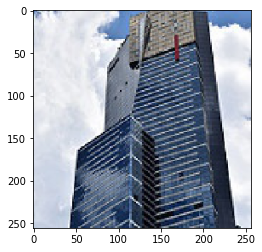

In [40]:
import tensorflow_io as tfio
rgb_image = load_img('/content/gdrive/MyDrive/Thesis/Dataset/test/few_image/20057.jpg', target_size=(256,256))
#gray_image = ImageOps.grayscale(rgb_image)
# gray_image = tf.image.rgb_to_grayscale(rgb_image)
# convert to numpy array
rgb_pixels = img_to_array(rgb_image)
rgb_pixels = rgb_pixels/255.0
# rgb_pixels = tf.image.convert_image_dtype(rgb_pixels, dtype=tf.float32) # to normalize the rgb pixels
lab = tfio.experimental.color.rgb_to_lab(rgb_pixels)
lab_pixel = (lab)/100.0
# rgb_np_array = np.array(rgb_pixels, dtype=float)

src = lab_pixel[:,:,0]
src = np.expand_dims(src, axis=2)
tar = lab_pixel[:,:,1:]
print(src.shape)
lab_gen = np.concatenate([src,tar],axis = 2)

lab_gen = (lab_gen*100)
rgb = tfio.experimental.color.lab_to_rgb(lab_gen)
rgb = np.array(rgb)
# print(rgb)
print(np.array(lab_pixel).max())
pyplot.imshow(rgb,'gray')
# lab_pixels = rgb2lab(1.0/255*rgb_np_array)
# gray_pixels = lab_pixels[:,:,0]
# ab_pixels = lab_pixels[:,:,1:]

In [68]:
# test_data = load_images('/content/gdrive/MyDrive/Thesis/Dataset/test/few_image/20056.jpg')
src_image, tar_image = load_single_images('/content/gdrive/MyDrive/Thesis/Dataset/skin_tone_clothing/png_images/IMAGES/img_0001.png')
# src_image, tar_image = preprocess_data(test_data)

In [69]:
print(src_image.shape)

# src_image = np.squeeze(src_image)
# src_image = np.expand_dims(src_image, axis=2)
print(src_image.shape)

(1, 256, 256, 3)
(1, 256, 256, 3)


In [70]:
# gen_image = model.predict(src_image)

In [71]:
src_image.shape

(1, 256, 256, 3)

In [72]:
gen_image = model.predict(src_image)
src_image = np.squeeze(src_image)
src_image = np.expand_dims(src_image, axis=2)
gen_image = np.squeeze(gen_image)

1/1 [==============================] - 0s 23ms/step


In [73]:
# gen_image = model.predict(src_image)
src_image = np.squeeze(src_image)
src_image = np.expand_dims(src_image[:,:,0], axis=2)
gen_image = np.squeeze(gen_image)
gen_image.shape

(256, 256, 2)

In [74]:
# lab_gen = np.concatenate([src_image,gen_image],axis = 2)

# lab_gen = (lab_gen*100)
# rgb = tfio.experimental.color.lab_to_rgb(lab_gen)
# rgb = np.array(rgb)
# # print(rgb)
# print(np.array(lab_gen).max())
# pyplot.imshow(rgb,'gray')

100.0


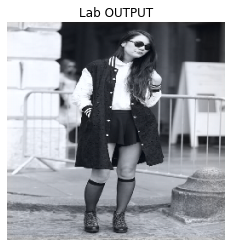

In [75]:
lab_gen = np.concatenate([src_image,gen_image],axis = 2)

lab_gen = (lab_gen*100)
rgb = tfio.experimental.color.lab_to_rgb(lab_gen)
rgb = np.array(rgb)
# print(rgb)
print(np.array(lab_gen).max())
pyplot.axis('off')
pyplot.imshow(rgb,'gray')
pyplot.title('Lab OUTPUT')
pyplot.show()

In [ ]:
from math import log10, sqrt
import cv2
import numpy as np

def PSNR(original, compressed):
	mse = np.mean((original - compressed) ** 2)
	if(mse == 0): # MSE is zero means no noise is present in the signal .
				# Therefore PSNR have no importance.
		return 100
	max_pixel = 255.0
	psnr = 20 * log10(max_pixel / sqrt(mse))
	return psnr

# original = cv2.imread("D:\Thesis\data\dataU\data\\20056.jpg")
# compressed = cv2.imread("D:\Thesis\data\dataU\data\\20057.jpg", 1)
# value = PSNR(original, compressed)
value = PSNR(tar_image, gen_image)
print(f"PSNR value is {value} dB")
	



PSNR value is 48.11653955755136 dB


In [ ]:
from math import log10, sqrt
import cv2
import numpy as np

def MAE(original, compressed):
	mae = np.mean(np.abs((original - compressed)))
	# if(mse == 0): # MSE is zero means no noise is present in the signal .
	# 			# Therefore PSNR have no importance.
	# 	return 100
	# mae =mae
	# psnr = 20 * log10(max_pixel / sqrt(mse))
	return mae

# original = cv2.imread("D:\Thesis\data\dataU\data\\20056.jpg")
# compressed = cv2.imread("D:\Thesis\data\dataU\data\\20057.jpg", 1)
# value = PSNR(original, compressed)
value = PSNR(gen_image, tar_image)
print(f"PSNR value is {value} dB")
	

PSNR value is 48.11653955755136 dB


In [ ]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity

def SSIM(original, compressed):
	(score, diff) = structural_similarity(original, compressed ,multichannel = True, full=True)
	return score

In [ ]:
s, t = load_images('/content/gdrive/MyDrive/Thesis/Dataset/div2k/DIV2K_train_HR/0004.png')

/content/gdrive/MyDrive/Thesis/Dataset/div2k/DIV2K_train_256/0013.png
1/1 [==============================] - 0s 19ms/step
(256, 256, 2) (256, 256, 1)
0.4259301783326775
/content/gdrive/MyDrive/Thesis/Dataset/div2k/DIV2K_train_256/0005.png
1/1 [==============================] - 0s 19ms/step
(256, 256, 2) (256, 256, 1)
0.46088558429875137
/content/gdrive/MyDrive/Thesis/Dataset/div2k/DIV2K_train_256/0010.png
1/1 [==============================] - 0s 19ms/step
(256, 256, 2) (256, 256, 1)
0.4527976269167326
/content/gdrive/MyDrive/Thesis/Dataset/div2k/DIV2K_train_256/0003.png
1/1 [==============================] - 0s 18ms/step
(256, 256, 2) (256, 256, 1)
0.4299328004041592
/content/gdrive/MyDrive/Thesis/Dataset/div2k/DIV2K_train_256/0002.png
1/1 [==============================] - 0s 18ms/step
(256, 256, 2) (256, 256, 1)
0.4316456973981216
/content/gdrive/MyDrive/Thesis/Dataset/div2k/DIV2K_train_256/0001.png
1/1 [==============================] - 0s 18ms/step
(256, 256, 2) (256, 256, 1)
0.35

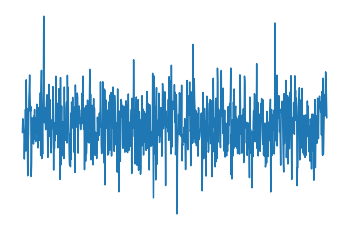

In [ ]:
import cv2
test_img_path = '/content/gdrive/MyDrive/Thesis/Dataset/div2k/DIV2K_train_256'
save_path = 'D:\Thesis\output\RGB_PASCAL_DIV2K'+'\\'
psnr_list = []
for filename in listdir(test_img_path):
    print(test_img_path+'/'+filename)
    img = cv2.imread(test_img_path+filename)
    src_image, tar_image = load_images(test_img_path+'/'+filename)

    
    # src_image, tar_image = preprocess_data(test_data)
    # generate image from source
    gen_image = model.predict(src_image)

    pyplot.axis('off')
    
    gen_image = np.squeeze(gen_image)

    src_image = np.squeeze(src_image)
    src_image = np.expand_dims(src_image, axis=2)

    print(gen_image.shape,src_image.shape)

    lab_gen = np.concatenate([src_image,gen_image],axis = 2)

    lab_gen = (lab_gen*100)
    rgb = tfio.experimental.color.lab_to_rgb(lab_gen)
    rgb = np.array(rgb)

    tar_image = np.squeeze(tar_image)
    
    lab_tar = np.concatenate([src_image,tar_image],axis = 2)

    lab_tar = (lab_tar*100)
    rgb_tar = tfio.experimental.color.lab_to_rgb(lab_tar)
    rgb_tar = np.array(rgb_tar)


    psnr= SSIM(rgb_tar, rgb)
    # psnr = 
    print(psnr)
    psnr_list.append(psnr)
    

    # plot all three images
    # plot_images(src_image, gen_image, tar_image,save_path+filename)

    # print(img)
    # cv2.imwrite(save_path+filename,img)

plt.plot(psnr_list)
plt.show()

In [ ]:
import numpy as np
ps = np.array(psnr_list)
avg = ps.mean()
print('g100_1000x800_custom')
print("Avg",avg)
print("Max : ", ps.max())
print("Min : ",ps.min())

g100_1000x800_custom
Avg 47.83041004678831
Max :  49.79453278098241
Min :  45.57727081798126


In [ ]:
def result_show(test_data,filename):
    src_image, tar_image = test_data
    # generate image from source
    gen_image = model.predict(src_image)
    print(src_image.shape)
    # src_image = src_image[:,:,:]
    # src_image = np.squeeze(src_image)
    src_image = src_image.reshape((256,256,1))
    print(src_image.shape)
    gen_image = np.squeeze(gen_image)

    gen_Lab = np.concatenate([src_image, gen_image],axis = 2)
    gen_rgb = lab2rgb(gen_Lab)
    gen_rgb = np.array(gen_rgb).astype('uint8')

    tar_image = tar_image[0,:,:,:]
    print(gen_image.shape,src_image.shape,tar_image.shape)
    tar_Lab = np.concatenate([src_image, tar_image],axis = 2)
    tar_rgb = lab2rgb(tar_Lab)
    tar_rgb = np.array(tar_rgb).astype('uint8')

    save_path = 'D:\Thesis\output\hsv_PASCAL_VOC_g100\\'+filename
    

    # plot all three images
    # plot_images(src_image, gen_rgb, tar_rgb,save_path)
    plot_whole_images(src_image, gen_rgb, tar_rgb,save_path)


In [ ]:
# plot source, generated and target images
def plot_whole_images(src_img, gen_img, tar_img,path):
  
  # images = vstack(( gen_img, tar_img))
  #images = src_img
  # scale from [-1,1] to [0,1]
  # images = (images + 1) / 2.0
  p, ax = pyplot.subplots(1,3)
  titles = ['Source', 'Generated', 'Expected']
  # ax[0].subplot(1,3)
  ax[0].axis('off')
  src_image = np.squeeze(src_img)
  ax[0].imshow(src_image,'gray')
  # ax[0].title(titles[0])

  # ax[1].subplot(1,3,2)
  ax[1].axis('off')
  # re = np.squeeze(gen_image)
  ax[1].imshow(gen_img,'gray')
  # ax[1].title(titles[1])

  # ax[2].subplot(1,3,3)
  ax[2].axis('off')
  # re = np.squeeze(tar_image)
  ax[2].imshow(tar_img,'gray')
  # ax[2].title(titles[2])

  '''# plot images row by row
  for i in range(len(images)):
    
    # define subplot
    pyplot.subplot(1, 3, 2 + i)# turn off axis
    pyplot.axis('off')# plot raw pixel data
    pyplot.imshow(images[i])# show title
    pyplot.title(titles[i+1])
  print(images.shape)'''
  # pyplot.subplot(1,3,1)
  # pyplot.imshow(images[0,:,:,:])
  # cv2.imwrite(filename,)
  # img = pyplot.show()
  # plt.imsave(path,img)
  # p.savefig(path)


(1, 256, 256)
(256, 256, 1)
(256, 256, 2) (256, 256, 1) (256, 256, 2)


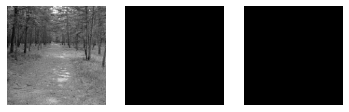

In [ ]:
result_show(test_data,"sdfhkjsdf")

In [ ]:
def postprocess_data(data):
	# load compressed arrays
	# unpack arrays
	# X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (data * 127.5) + 127.5
	# X2 = (X2 - 127.5) / 127.5
	return X1

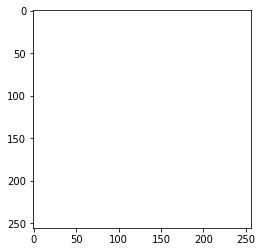

In [ ]:
gen_Lab = np.concatenate([src_image.reshape(256,256,1), tar_image[0,:,:,:]],axis = 2)
gen_Lab = lab2rgb(gen_Lab)
gen_Lab = postprocess_data(gen_Lab)
plt.imshow(gen_Lab,'gray')

In [ ]:
gen_Lab.shape

(256, 256, 3)

In [ ]:
gen_Lab.min()

127.5